In [1]:
#parameters

### USER EDIT start
esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
plotfolder='/g/data/tm70/ek4684/access-om3-paper-1/notebooks/mkfigs_output4'
dpi=300

### USER EDIT stop

import matplotlib as mpl
import os
%matplotlib inline
mpl.rcParams['figure.dpi']= dpi

os.makedirs(plotfolder, exist_ok=True)

# a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json
Plot folder path:  /g/data/tm70/ek4684/access-om3-paper-1/notebooks/mkfigs_output4


In [2]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime

In [3]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37801 instead
  warnings.warn(


/proxy/37801/status


## Load ACCESS-OM3 data from ESM datastore

In [4]:
datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [5]:
salt_flux_added_om3 = datastore.search(variable="salt_flux_added").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1}, 
        decode_timedelta=True, use_cftime=True))['salt_flux_added'].sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1933, 1, 1,calendar='noleap'))).resample(time = '1YE').mean('time').load()

In [6]:
surface_salt_om3 = datastore.search(variable="sos").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1}, 
        decode_timedelta=True, use_cftime=True))['sos'].sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1933, 1, 1,calendar='noleap'))).resample(time = '1YE').mean('time').load()

In [7]:
cell_area_om3 = datastore.search(variable='areacello',path=".*output000.*",).to_dask()
salt_flux_scaled_om3 = (salt_flux_added_om3 * cell_area_om3['areacello'])

## Load ACCESS-OM2 data from ACCESS-NRI Catalog

In [8]:
catalog = intake.cat.access_nri

In [9]:
var = catalog['025deg_jra55_ryf_era5comparison'].search(variable='sfc_salt_flux_restore',frequency="1mon")

In [10]:
salt_flux_added_om2 = var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)['sfc_salt_flux_restore'].sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1933, 1, 1,calendar='noleap'))).resample(time = '1YE').mean('time').load()

In [11]:
cell_area_om2 = catalog['025deg_jra55_ryf_era5comparison'].search(
    variable='area_t',
    path=".*output000.*").to_dask()

In [12]:
salt_flux_scaled_om2 = (salt_flux_added_om2 * cell_area_om2['area_t'])

In [13]:
var = catalog['025deg_jra55_ryf_era5comparison'].search(variable='surface_salt',frequency="1mon")
surface_salt_om2 = var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)['surface_salt'].sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1933, 1, 1,calendar='noleap'))).resample(time = '1YE').mean('time').load()

In [14]:
# Define regions, plot settings, and colors
regions = {
    "Baltic Sea": {"lat1": 53, "lat2": 66, "lon1": 18, "lon2": 30, "color": "blue"},
    "Med Sea": {"lat1": 31, "lat2": 41, "lon1": 0, "lon2": 35, "color": "green"},
    "Red Sea": {"lat1": 12, "lat2": 29, "lon1": 33, "lon2": 44, "color": "orange"},
    "Persian Gulf": {"lat1": 24, "lat2": 31, "lon1": 47, "lon2": 56, "color": "purple"},
    "White Sea": {"lat1": 63, "lat2": 68, "lon1": 31, "lon2": 41, "color": "red"},
}

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 207.02 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 195.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 207.02 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 195.78 MiB.
This may cause some s

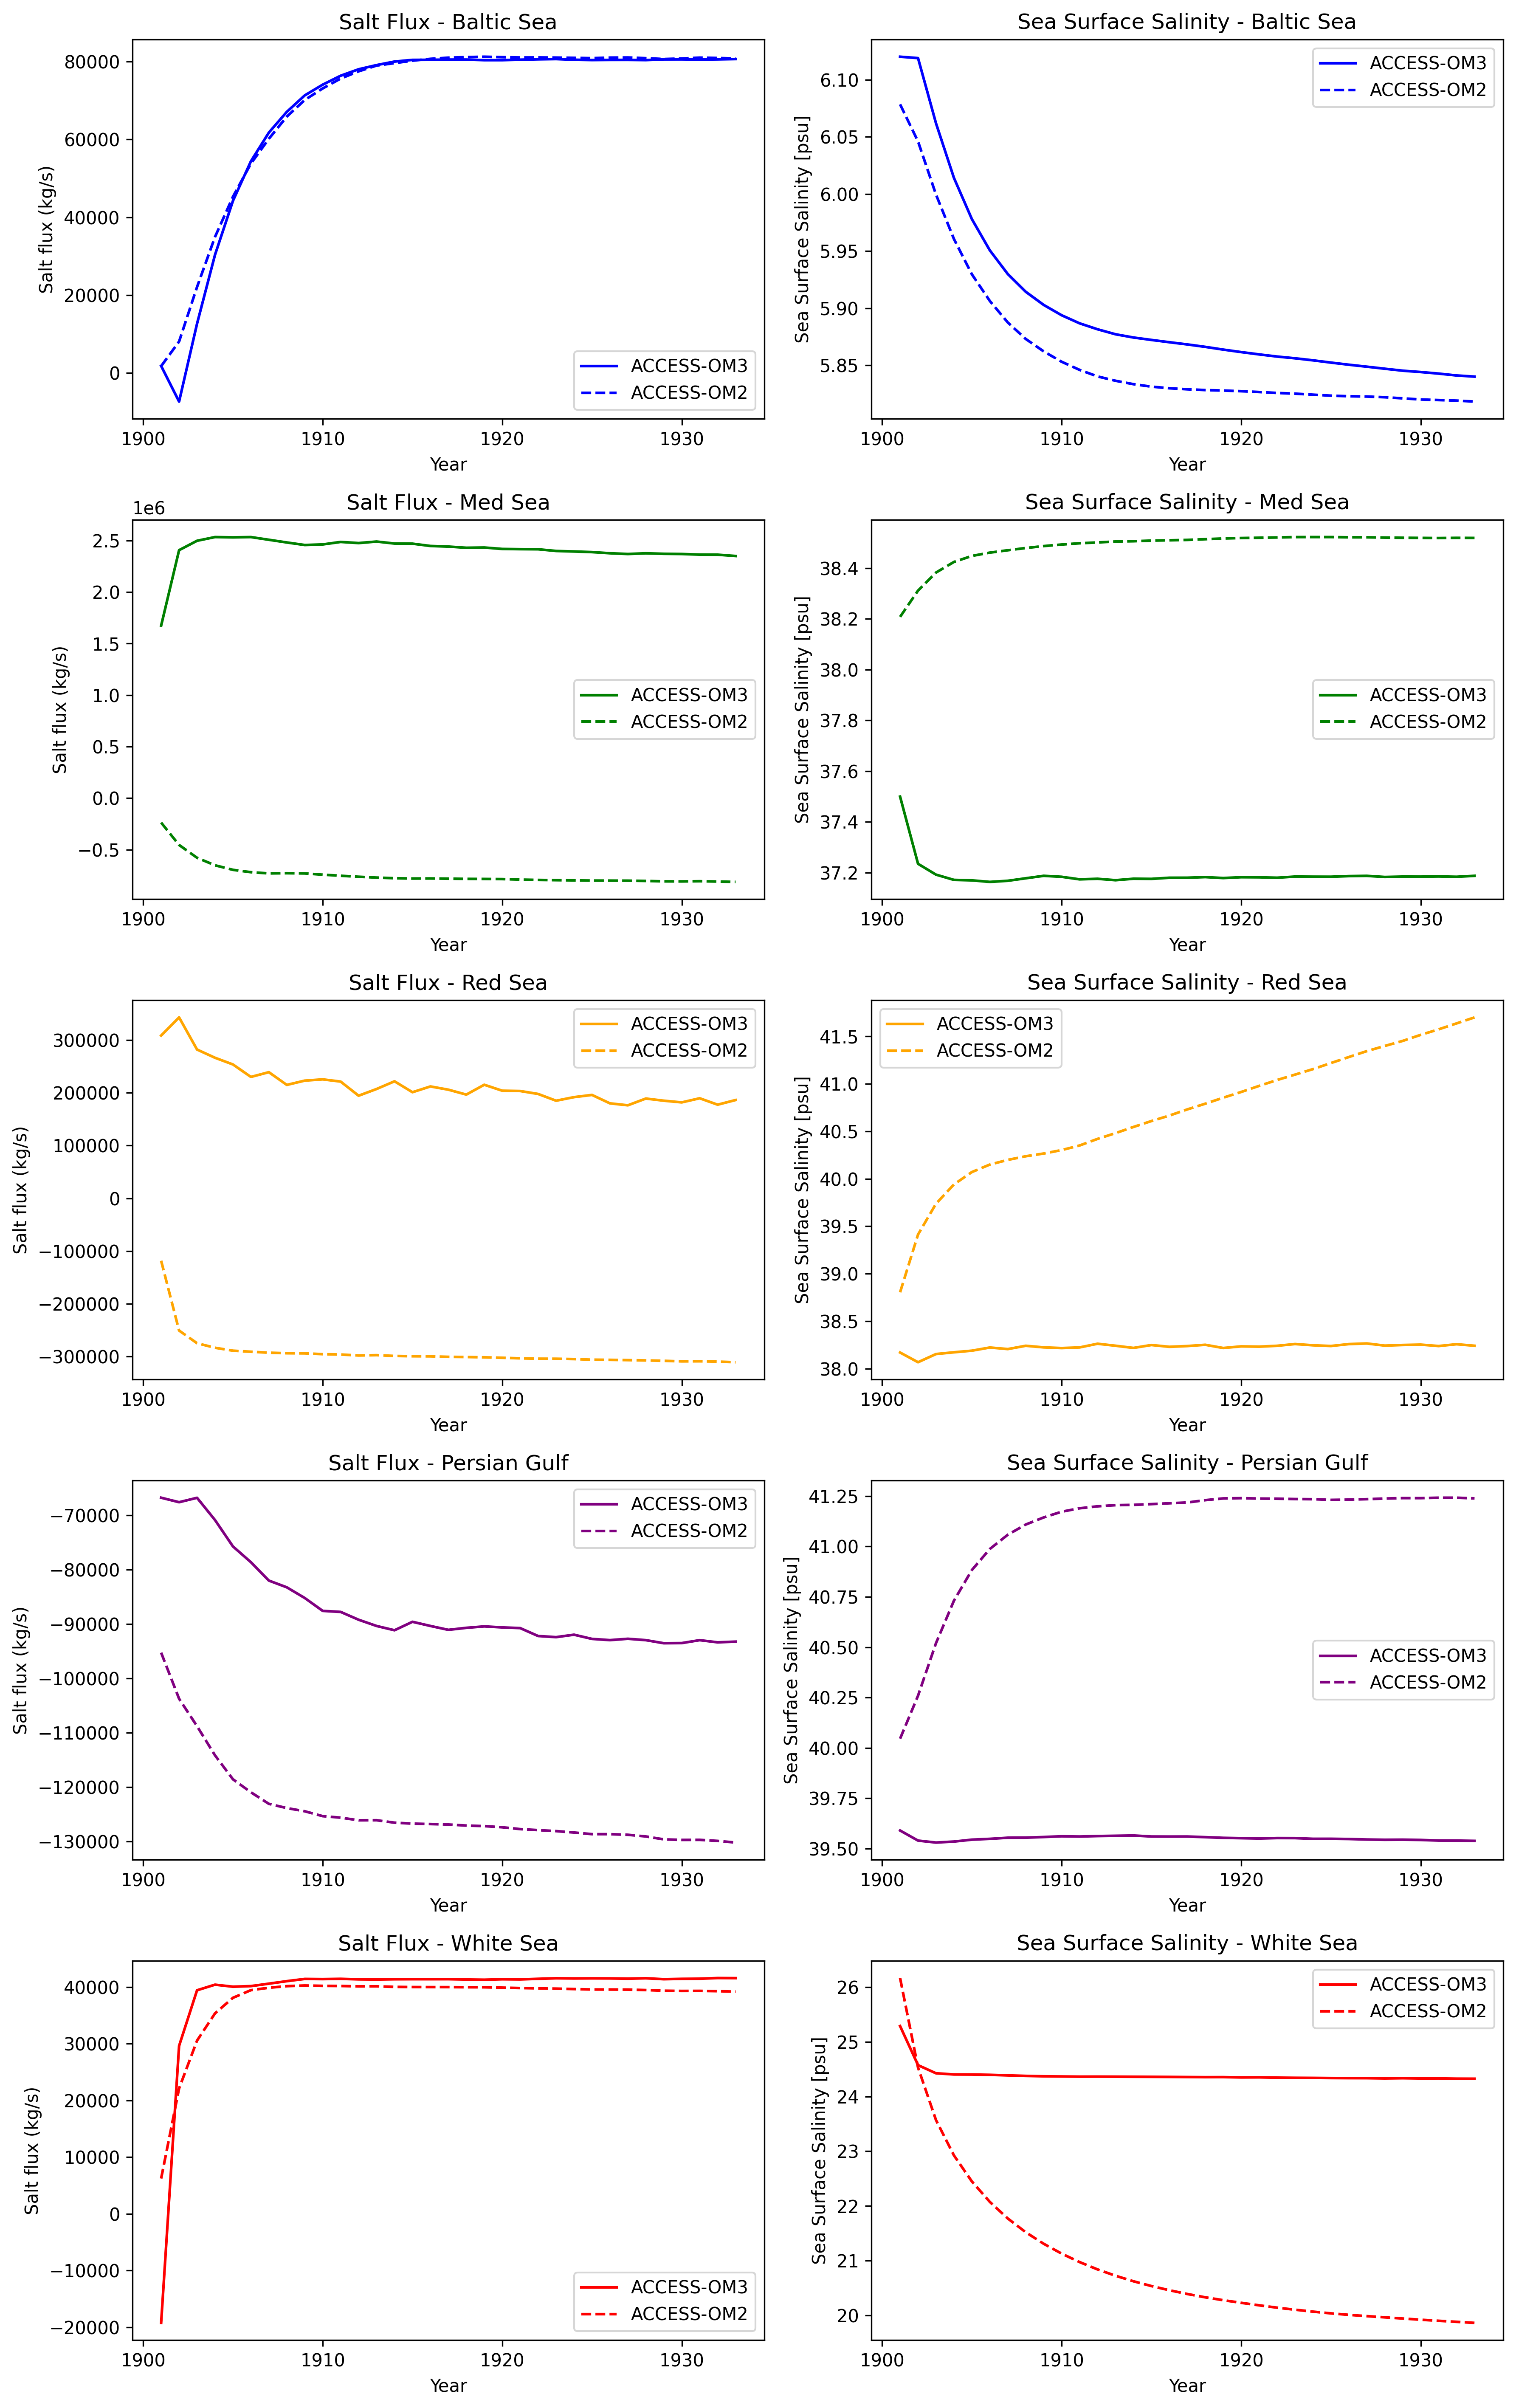

In [17]:
fig, axes = plt.subplots(
    nrows=len(regions), ncols=2, figsize=(12, 19))

for i, (region, bounds) in enumerate(regions.items()):
    salt_restore_OM3 = (
        salt_flux_scaled_om3
        .sel(xh=slice(bounds["lon1"], bounds["lon2"])).sum('xh')
        .sel(yh=slice(bounds["lat1"], bounds["lat2"])).sum('yh')
    )
    salt_restore_OM2 = (
        salt_flux_scaled_om2
        .sel(xt_ocean=slice(bounds["lon1"], bounds["lon2"])).sum('xt_ocean')
        .sel(yt_ocean=slice(bounds["lat1"], bounds["lat2"])).sum('yt_ocean')
    )

    salinity_OM3 = (
        surface_salt_om3
        .sel(xh=slice(bounds["lon1"], bounds["lon2"])).mean('xh')
        .sel(yh=slice(bounds["lat1"], bounds["lat2"])).mean('yh')
    )
    salinity_OM2 = (
        surface_salt_om2
        .sel(xt_ocean=slice(bounds["lon1"], bounds["lon2"])).mean('xt_ocean')
        .sel(yt_ocean=slice(bounds["lat1"], bounds["lat2"])).mean('yt_ocean')
    )

    ax1 = axes[i, 0]
    salt_restore_OM3.plot(ax=ax1, color=bounds["color"], label="ACCESS-OM3")
    salt_restore_OM2.plot(ax=ax1, linestyle='--', color=bounds["color"], label="ACCESS-OM2")
    ax1.set_ylabel("Salt flux (kg/s)")
    ax1.set_title(f"Salt Flux - {region}")
    ax1.set_xlabel("Year")
    ax1.legend()

    ax2 = axes[i, 1]
    salinity_OM3.plot(ax=ax2, linestyle='-', color=bounds["color"], label="ACCESS-OM3")
    salinity_OM2.plot(ax=ax2, linestyle='--', color=bounds["color"], label="ACCESS-OM2")
    ax2.set_ylabel("Sea Surface Salinity [psu]")
    ax2.set_title(f"Sea Surface Salinity - {region}")
    ax2.set_xlabel("Year")
    ax2.legend()
plt.tight_layout()
plt.savefig("/g/data/tm70/ek4684/Evaluation/Salinity_restoring_025_deg_all_regions.png", dpi=300)
plt.show()